In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys 
from tqdm import tqdm
sys.path.append('/home/drdarby/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
from scipy.interpolate import griddata
import xgcm
print(xgcm.__path__)


['/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/xgcm']


In [5]:
path_llc270 = '/media/drdarby/Elements/data/llc270/'

THETA_files, THETA_filepaths = tools.get_data_paths_from_binary(path_llc270, 'THETA_snap', file_end = 'nc' )
ETAN_files, ETAN_filepaths = tools.get_data_paths_from_binary(path_llc270, 'ETAN_snap', file_end = 'nc' )

ADVr_TH_files, ADVr_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'ADVr_TH', file_end = 'nc' )
ADVx_TH_files, ADVx_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'ADVx_TH', file_end = 'nc' )
ADVy_TH_files, ADVy_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'ADVy_TH', file_end = 'nc' )
DFxE_TH_files, DFxE_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'DFxE_TH', file_end = 'nc' )
DFyE_TH_files, DFyE_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'DFyE_TH', file_end = 'nc' )
DFrE_TH_files, DFrE_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'DFrE_TH', file_end = 'nc' )
DFrI_TH_files, DFrI_TH_filepaths = tools.get_data_paths_from_binary(path_llc270, 'DFrI_TH', file_end = 'nc' )
TFLUX_files, TFLUX_filepaths = tools.get_data_paths_from_binary(path_llc270, 'TFLUX', file_end = 'nc' )
oceQsw_files, oceQsw_filepaths = tools.get_data_paths_from_binary(path_llc270, 'oceQsw', file_end = 'nc' )

THETA = xr.open_mfdataset(THETA_filepaths).isel(tile = 6)
ETAN = xr.open_mfdataset(ETAN_filepaths).isel(tile = 6)
ADVr_TH = xr.open_mfdataset(ADVr_TH_filepaths[24]).isel(tile = 6)
ADVx_TH = xr.open_mfdataset(ADVx_TH_filepaths[24]).isel(tile = 6)
ADVy_TH = xr.open_mfdataset(ADVy_TH_filepaths[24]).isel(tile = 6)
DFxE_TH = xr.open_mfdataset(DFxE_TH_filepaths[24]).isel(tile = 6)
DFyE_TH = xr.open_mfdataset(DFyE_TH_filepaths[24]).isel(tile = 6)
DFrE_TH = xr.open_mfdataset(DFrE_TH_filepaths).isel(tile = 6)
DFrI_TH = xr.open_mfdataset(DFrI_TH_filepaths).isel(tile = 6)
TFLUX = xr.open_mfdataset(TFLUX_filepaths).isel(tile = 6)
oceQsw = xr.open_mfdataset(oceQsw_filepaths).isel(tile = 6)

In [11]:
grid_files, grid_filepaths = tools.get_data_paths_from_binary(path_llc270, 'Grid', file_end = 'nc' )
grid = xr.open_mfdataset(grid_filepaths[6])
grid = grid.rename({'i1':'k','i2':'j','i3':'i'})
grid['i'] = (grid['i']-1).astype(int)
grid['j'] = (grid['j']-1).astype(int)
grid['k'] = (grid['k'] -1).astype(int)

## Heat Budget Closure:

### Heat budget equation
The heat budget for the MITgcm is based on this equation:

$\frac{\partial \theta}{\partial t}$ $=$ $-$ $\nabla$ $\cdot$ $(\theta$ $\mathbf{u})$ $-$ $\nabla$ $\cdot$ $F_{\textrm{diff}}^{\theta}$ $+$ ${F}_\textrm{forc}^{\theta}$

where, $\frac{\partial \theta}{\partial t}$ is the change in potential temperature over time. The equation above describes this change as a function of the convergence (the $-\nabla \cdot$ operator) of heat advection and diffusion with the addition of any forcing terms.

In order to simulate this equation and be used for MITgcm, a two steps are needed. 1) A coordinate change to best represent the free surface with fixed depth bins $z^* = \frac{z - \eta}{H + \eta}H $, where $\eta$ and $H$ are the displacement of the ocean surface and the ocean depth respectively, and 2) the residual mean velocities,

$v_{res}$ = $(u_{res},v_{res},w_{res})$ $=$ $(u,v,w)$ $+$ $(u_b,v_b,w_b)$, 

that parameterizes unresolved eddies. From step 1, our coordinate change introduces a scaling factor $s^* = 1+ \frac{\eta}{H}$ as well as a change to our horizontal and vertical divergences, $ ( \nabla_z^* $ and $\frac{\partial}{\partial z^{*}} )$, which are seperated, leading to our final equation:

$\frac{\partial(s^*\theta)}{\partial t}$ $=$ $-\nabla_{z^{*}}$ $\cdot(s^*\theta\,\mathbf{v}_{res})$ $-\frac{\partial(\theta\,w_{res})}{\partial z^{*}}$ $-$ $s^*$ $(\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta})$$+$$s^*$ ${F}_\textrm{forc}^{\theta}$

In order to make the calculation a bit easier on the eyes the different budget terms will be seperated into: 

$\underbrace{\frac{\partial(s^*\theta)}{\partial t}}_{G^{\theta}_\textrm{total}} = \underbrace{-\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res}) - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}}_{G^{\theta}_\textrm{advection}}\underbrace{- s^* ({\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}})}_{G^{\theta}_\textrm{diffusion}} + \underbrace{s^* {F}_\textrm{forc}^{\theta}}_{G^{\theta}_\textrm{forcing}}$

Making our budget equation: $G^{\theta}_\textrm{total} = G^{\theta}_\textrm{advection} + G^{\theta}_\textrm{diffusion} + G^{\theta}_\textrm{forcing}$

### Converting to MITgcm output

#### Calculating $G^{\theta}_\textrm{total}$
In order to calculate the $G^{\theta}_\textrm{total}$ snapshots of our model feild are needed for $\eta$ and $\theta$. This is because averaging these fields would smooth out variability and we would lose information.

$G^{\theta}_\textrm{total} = \frac{\partial(s^*\theta)}{\partial t} = \frac{\partial(1+ \frac{\eta}{H}) \theta}{\partial t}$
in terms of our variables our $G^{\theta}_\textrm{total}$ would be:
$=$ 
```sTHETA.diff(dim = 'time') = THETA_snapshot*(1+ETAN_snapshot/grid.Depth).diff(dim = 'time')/delta_t```

where ```.diff(dim= 'time')``` is the numpy difference function with respect to the time column, and grid.Depth is the Depth vaiable from out MITgcm grid.




In [65]:
sTHETA = THETA['THETA']*(1+ETAN['ETAN']/grid.Depth.where(grid.Depth!=0))
sTHETA_dt = sTHETA.diff(dim = 'time',label='lower')

delta_t = sTHETA['time'].diff(dim='time',label='lower')/np.timedelta64(1,'s')
#delta_t.coords['time'] = np.array(ADVr_TH.isel(time=slice(0,11)).time)
d_sTHETA_dt = sTHETA_dt/delta_t

In [63]:
d_sTHETA_dt

<xarray.DataArray (time: 11, k: 50, j: 270, i: 270)>
dask.array<truediv, shape=(11, 50, 270, 270), dtype=float64, chunksize=(11, 50, 270, 270), chunktype=numpy.ndarray>
Coordinates:
    tile      int64 6
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i         (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    timestep  (time) int64 635472 637704 639864 642096 ... 653112 655272 657504
  * time      (time) datetime64[ns] 2016-03-01 2016-04-01 ... 2017-01-01

### Calculating $G^{\theta}_\textrm{advection}$

At first glance, in order to calculate our $G^{\theta}_\textrm{horizontal advection} = -\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res})$  equation, some tough coding are needed. Fortunately, there exists output of the $\theta$ advection terms in the x and y.

Making our equation $G^{\theta}_\textrm{horizontal advection}$:
$=$
```-1*(ADVx_TH.diff(dim='X') + ADVy_TH.diff(dim='Y'))```


next we calculate our vertical advection term $G^{\theta}_\textrm{vertical advection} = - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}$

$=$
```ADVr_TH.diff(dim='Z')```

putting it all together we have,

$G^{\theta}_\textrm{advection}$ = ```(-1*(ADVx_TH.diff(dim='X') + ADVy_TH.diff(dim='Y')) + ADVr_TH.diff(dim='Z'))/volume```

where,
```volume = (grid.rA*grid.drF*grid.hFacC)```

In [2]:
CellVol = grid['RAC'] * grid['DRF'] * grid['hFacC']

NameError: name 'grid' is not defined

In [54]:
adv_hz_x = ADVx_TH['ADVx_TH'].where(grid.hFacC.values > 0,0).diff(dim='i_g',label='lower')
adv_hz_y = ADVy_TH['ADVy_TH'].where(grid.hFacC.values > 0,0).diff(dim='j_g',label='lower')
adv_vt = ADVr_TH['ADVr_TH'].where(grid.hFacC.values > 0,0).diff(dim='k_l',label='lower')
adv_hz_y = adv_hz_y.rename({'j_g':'j'})
adv_hz_x = adv_hz_x.rename({'i_g':'i'})
adv_vt = adv_vt.rename({'k_l':'k'})


In [ ]:
G_adv = (-1*(adv_hz_x[:,:-1,:-1,:] + adv_hz_y[:,:-1,:,:-1]) + adv_vt[:,:,:-1,:-1])/CellVol[:-1,:-1,:-1].where(CellVol[:-1,:-1,:-1]!=0)

#### Calculating $G^{\theta}_\textrm{diffusion}$


The form of our diffusion term is almost identical to our advection term except for the variables used. Our horizontal and vertical components are:

$G^{\theta}_\textrm{horizontal diffusion}$
$=$ ```-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')))```

and, 
$G^{\theta}_\textrm{vertical diffusion}$ $=$ ```DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z')```

In [55]:
DFxE_TH = DFxE_TH.rename({'i_g':'i'}).where(grid.hFacC.values > 0,0)
DFyE_TH = DFyE_TH.rename({'j_g':'j'}).where(grid.hFacC.values > 0,0)
DFrE_TH = DFrE_TH.rename({'k_l':'k'}).where(grid.hFacC.values > 0,0)
DFrI_TH = DFrI_TH.rename({'k_l':'k'}).where(grid.hFacC.values > 0,0)

ValueError: cannot rename 'i_g' because it is not a variable or dimension in this dataset

Making our final $G^{\theta}_\textrm{diffusion}$ term:

$G^{\theta}_\textrm{diffusion} = $ ``` (-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')) + DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z'))/volume```

If you are using the KPP parameter, the KPP term has to be added to the $G^{\theta}_\textrm{diffusion}$.

$G^{\theta}_\textrm{diffusion with kpp} = $ ``` (-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')) + DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z')+KPPg_TH.diff(dim='Z'))/volume```

In [56]:
dif_hConvH = -1*(DFxE_TH['DFxE_TH'].diff('i',label='lower')[:,:-1,:-1] + DFyE_TH['DFyE_TH'].diff('j',label='lower')[:,:,:,:-1])
dif_vConvH = DFrE_TH['DFrE_TH'].diff('k',label='lower')+DFrI_TH['DFrI_TH'].diff('k',label='lower')

In [ ]:
G_diff = (dif_hConvH + dif_vConvH)/CellVol[:-1,:-1,:-1].where(CellVol[:-1,:-1,:-1]!=0)

#### Calculating $G^{\theta}_\textrm{forcing}$

To complete our heat budget we must finally calculate our forcing term. This term consists of surface and subsurface forcing, including shortwave radiation and temperature flux. These are ultimatly subtracted from one another, however, the shortwave radiation is scaled by its penetration depth into the water column eventually zeroing out.

#### constants:

In [15]:
# Seawater density (kg/m^3)
rhoConst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

In [75]:
depths = grid['RC']
k = np.arange(50)
q1 = np.array(R*np.exp(1.0/zeta1*depths[:-1]) + (1.0-R)*np.exp(1.0/zeta2*depths[:-1]))
q2 = np.array(R*np.exp(1.0/zeta1*depths[1:]) + (1.0-R)*np.exp(1.0/zeta2*depths[1:]))
q1 = np.append(q1,0)
q2 = np.append(q2,0)
q1 = xr.DataArray(q1,coords=[k],dims=['k'])
q2 = xr.DataArray(q2,coords=[k],dims=['k'])
q1 = q1.where(k<17,0) #correction for no heat pen past 200m
q2 = q2.where(k<17,0)
mskC = grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1
#subsurface heat
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw['oceQsw']).transpose('time','k','j','i').isel(k=slice(1,50))
# Surface heat flux (W/m^2)
forcH_surf = ((TFLUX['TFLUX'] - (1-(q1[0]-q2[0]))*oceQsw['oceQsw'])\
              *mskC[0]).transpose('time','j','i').assign_coords(k=0).expand_dims('k')

In [80]:
forcH = xr.concat([forcH_surf,forcH_subsurf], dim='k')
G_forcing = ((forcH)/(rhoConst*c_p))/(grid['hFacC']*grid['DRF'].where(CellVol!=0))

array([-5.00000000e+00, -1.50000000e+01, -2.50000000e+01, -3.50000000e+01,
       -4.50000000e+01, -5.50000000e+01, -6.50000000e+01, -7.50049973e+01,
       -8.50250015e+01, -9.50950012e+01, -1.05309998e+02, -1.15870003e+02,
       -1.27150002e+02, -1.39740005e+02, -1.54470001e+02, -1.72399994e+02,
       -1.94735001e+02, -2.22710007e+02, -2.57470001e+02, -2.99929993e+02,
       -3.50679993e+02, -4.09929993e+02, -4.77470001e+02, -5.52710022e+02,
       -6.34734985e+02, -7.22400024e+02, -8.14469971e+02, -9.09739990e+02,
       -1.00715503e+03, -1.10590503e+03, -1.20553503e+03, -1.30620496e+03,
       -1.40915002e+03, -1.51709497e+03, -1.63417505e+03, -1.76513501e+03,
       -1.91415002e+03, -2.08403491e+03, -2.27622510e+03, -2.49125000e+03,
       -2.72925000e+03, -2.99025000e+03, -3.27425000e+03, -3.58125000e+03,
       -3.91125000e+03, -4.26425000e+03, -4.64025000e+03, -5.03925000e+03,
       -5.46125000e+03, -5.90625000e+03])

#### Checking to see if LHS and RHS terms match:
##### surface:

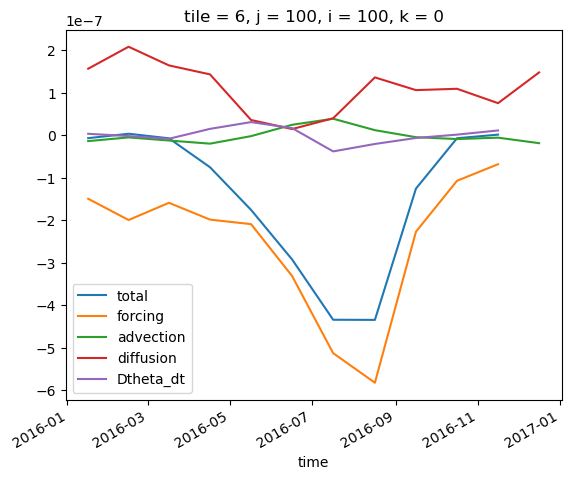

In [25]:
(G_forcing[:,:,:-1,:-1].isel(k=0,i=100,j=100) + G_adv.isel(k=0,i=100,j=100) + G_diff.isel(k=0,i=100,j=100)).plot(label='total')
G_forcing[:-1,:-1].isel(k=0,i=100,j=100).plot(label='forcing')
G_adv.isel(k=0,i=100,j=100).plot(label='advection')
G_diff.isel(k=0,i=100,j=100).plot(label='diffusion')
d_sTHETA_dt.isel(k=0,i=100,j=100).plot(label='Dtheta_dt')

plt.legend()

##### subsurface:

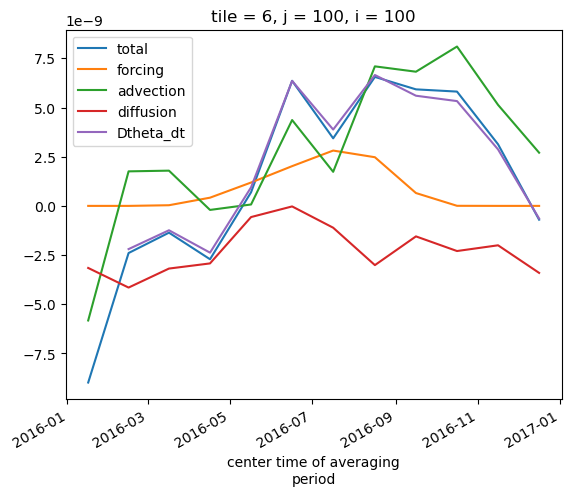

In [77]:
d_sTHETA_dt.coords['time'] = G_forcing.isel(time=slice(1,12)).time # time correction
(G_forcing[:-1,:,:-1,:-1].isel(k=slice(1,49),i=100,j=100) + G_adv.isel(k=slice(1,49),i=100,j=100) + G_diff.isel(k=slice(1,49),i=100,j=100)).mean(dim='k').plot(label='total')
G_forcing[:-1,:].isel(k=slice(1,49),i=100,j=100).mean(dim='k').plot(label='forcing')
G_adv.isel(k=slice(1,49),i=100,j=100).mean(dim='k').plot(label='advection')
G_diff.isel(k=slice(1,49),i=100,j=100).mean(dim='k').plot(label='diffusion')
d_sTHETA_dt.isel(k=slice(1,49),i=100,j=100).mean(dim='k').plot(label='Dtheta_dt')
#plt.ylim(-1e-6,1e-6)
plt.legend()

There is a good matching for subsurface values, however surface values do not match sufficiently for closure. The culprate seems to be the forcing term at the surface. Is sea ice also included in these calculations?

## Volume Budget Closure

### Volume budget equation

Our volume tendency can be writen as the integral equation:
$\underbrace{\frac{\partial \eta}{\partial t}}_{G_\text{total tendency}} = \underbrace{\int_{-H}^0 \left( -\nabla_{z^*}(s^*\,{\bf v})- \frac{\partial w}{\partial z^*} \right) dz^*}_{G_{\text{volumetric divergence}}} + \underbrace{F}_{{G_{surface fluxes}}}$

Where $H$ is the depth and $\frac{\partial w}{\partial z^*}$ is the vertical velocity gradient.

Where, similar to the heat budget, our volume budget can be written as:

$G_\text{total tendency} = G_{\text{volumetric divergence}} + G_{surface fluxes}$



#### Calculating $G_\text{total tendency}$
Our total tendency can be calculated similar to that of our $G_{total}$

$\frac{\partial \eta}{\partial t} =$ ```ETAN.diff(dim='time')/delta_t ```

In [7]:
d_eta = ETAN['ETAN'].diff(dim='time',label='lower')
delta_t = ETAN['time'].diff(dim='time',label='lower')/np.timedelta64(1,'s')
d_eta_dt = d_eta/delta_t

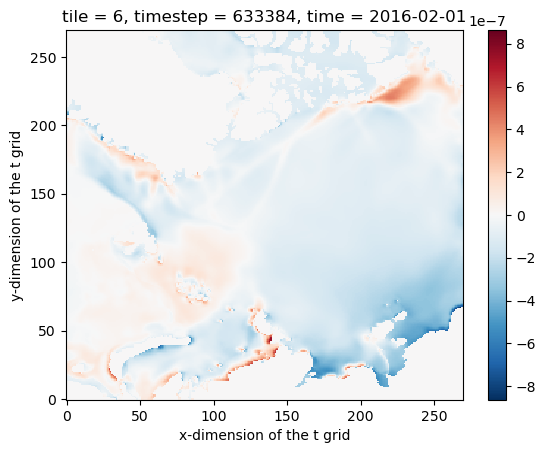

In [9]:
d_eta_dt.isel(time=0).plot()

#### Calculating $G_{surface fluxes}$

In [31]:
oceFWflx_files, oceFWflx_filepaths = tools.get_data_paths_from_binary(path_llc270, 'oceFWflx', file_end = 'nc' )
oceFWflx = xr.open_mfdataset(oceFWflx_filepaths).isel(tile=6)
WVELMASS_files, WVELMASS_filepaths = tools.get_data_paths_from_binary(path_llc270, 'WVELMASS', file_end = 'nc' )
WVELMASS = xr.open_mfdataset(WVELMASS_filepaths).isel(tile=6)


In [32]:
G_surf_flx = oceFWflx['oceFWflx']/rhoConst

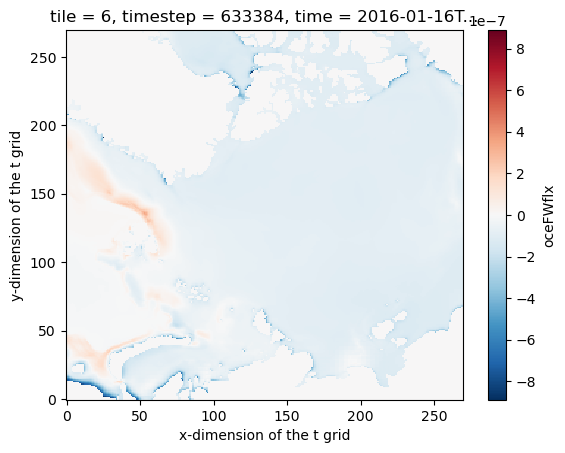

In [96]:
G_surf_flx.isel(time=0).plot()

#### Calculating $G_{\text{volumetric divergence}}$
Again, at first glance a scary integration looks to be needed, however, we can simply sum the parts of vertical flux divergence and horizontal flux divergence using WVELMASS, UVELMASS, and VVELMASS. Where $G_{\text{volumetric divergence}}$ can be broken up further into $G_{\text{volumetric divergence}} = G_{\text{vertical divergence}} + G_{\text{horizontal divergence}}$

$G_{\text{vertical divergence}}$

In [48]:
vol_transport_z = WVELMASS['WVELMASS'] * grid.RAC

In [45]:
vol_transport_z = vol_transport_z.where(grid.hFacC.values > 0,0)


In [53]:
vol_transport_z[:,0,:,:] = np.zeros((np.shape(vol_transport_z[:,0,:,:]))) #set surface values to zero

In [110]:
vol_vert_divergence = vol_transport_z.diff(dim='k_l',label='lower')

In [111]:
G_vertical_flux_divergence = (vol_vert_divergence / grid.RAC).rename({'k_l':'k'})

In [112]:
G_vertical_flux_divergence_integrated = G_vertical_flux_divergence.sum('k')

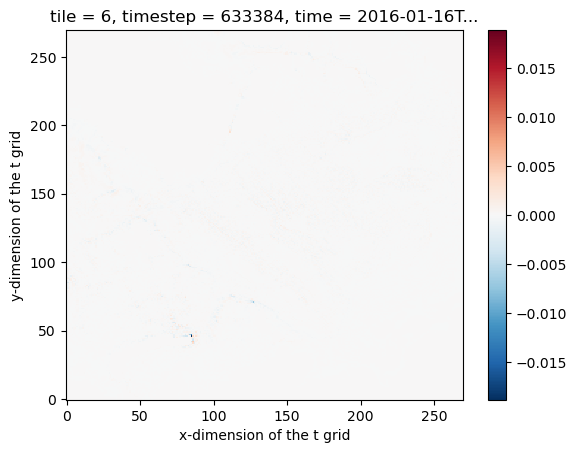

In [98]:
G_vertical_flux_divergence_integrated.isel(time=0).plot()

$G_{\text{horizontal divergence}}$

In [61]:
UVELMASS_files, UVELMASS_filepaths = tools.get_data_paths_from_binary(path_llc270, 'UVELMASS', file_end = 'nc' )
VVELMASS_files, VVELMASS_filepaths = tools.get_data_paths_from_binary(path_llc270, 'VVELMASS', file_end = 'nc' )
UVELMASS = xr.open_mfdataset(UVELMASS_filepaths[24]).isel(tile = 6)
VVELMASS = xr.open_mfdataset(VVELMASS_filepaths[24]).isel(tile = 6)


In [68]:
VVELMASS

<xarray.Dataset>
Dimensions:   (j_g: 270, k: 50, i: 270, time: 12)
Coordinates:
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    tile      int64 6
  * i         (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    timestep  (time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
Data variables:
    VVELMASS  (time, k, j_g, i) float32 dask.array<chunksize=(12, 50, 270, 270), meta=np.ndarray>

In [74]:
vol_transport_x = UVELMASS['UVELMASS'].rename({'i_g':'i'}) * grid.DYG * grid.DRF
vol_transport_y = VVELMASS['VVELMASS'].rename({'j_g':'j'}) * grid.DXG * grid.DRF

In [75]:
vol_transport_x = vol_transport_x.where(grid.hFacC.values > 0,0)
vol_transport_y = vol_transport_y.where(grid.hFacC.values > 0,0)

In [113]:
vol_horiz_divergence = vol_transport_x.diff(dim='i',label='lower')[:,:,:-1,:] + vol_transport_y.diff(dim='j',label='lower')[:,:,:,:-1]

In [79]:
G_vol_horiz_divergence = -vol_horiz_divergence/grid.RAC
G_vol_horiz_divergence_integrated = G_vol_horiz_divergence.sum('k')

In [114]:
G_rhs = G_vol_horiz_divergence_integrated - G_vertical_flux_divergence_integrated[:,:-1,:-1] + G_surf_flx.assign_coords(k=0).expand_dims('k').sum('k')[:,:-1,:-1]

In [105]:
G_rhs.isel(time=slice(1,12))
d_eta_dt.coords['time'] = G_rhs.isel(time=slice(1,12)).time


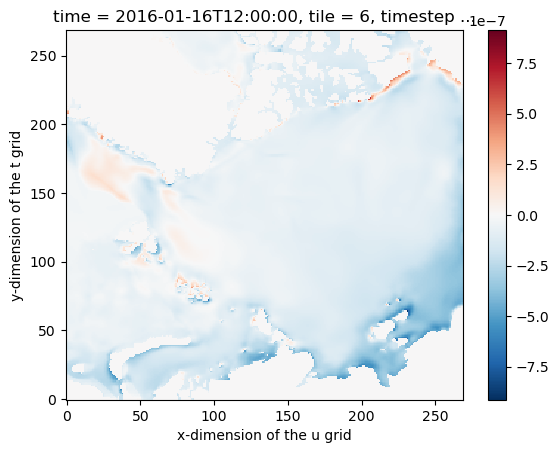

In [115]:
G_rhs.isel(time=0).plot()

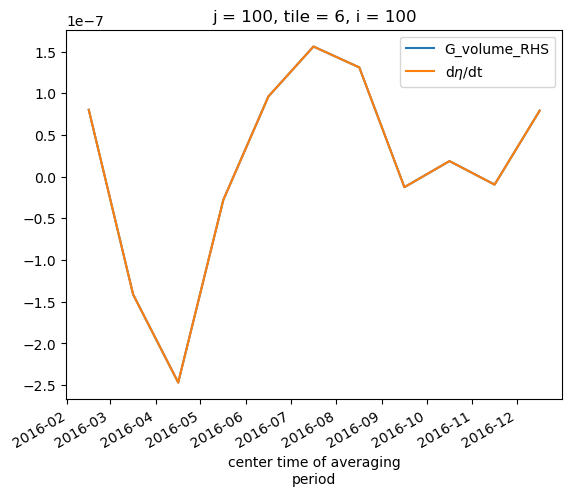

In [119]:
G_rhs.isel(time=slice(1,12),j=100,i=100).plot(label='G_volume_RHS')
d_eta_dt.isel(j=100,i=100).plot(label='d$\eta$/dt')
plt.legend()

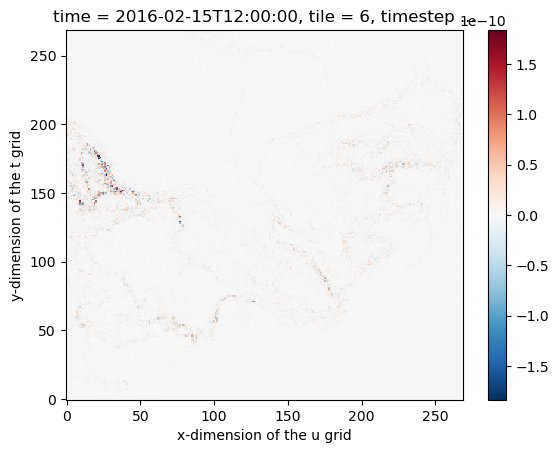

In [122]:
(G_rhs.isel(time=slice(1,12)).isel(time=0) - d_eta_dt.isel(time=0)).plot()

In [ ]:
d_eta_dt